In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Tensorflow version: 2.2.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
df=pd.read_csv("/content/drive/My Drive/anomaly detection/AABA_2006-01-01_to_2018-01-01.csv",parse_dates=['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
1,2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2,2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
3,2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
4,2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA


In [5]:
df.shape

(3019, 7)

In [6]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                    mode='lines',
                    name='close'))
fig.update_layout(showlegend=True)
fig.show()

In [7]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(2415, 7) (604, 7)


In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

In [0]:
def create_dataset(X, y, timestep=1):
    Xs, ys = [], []
    for i in range(len(X) - timestep):
        v = X.iloc[i:(i + timestep)].values
        Xs.append(v)        
        ys.append(y.iloc[i + timestep])
    return np.array(Xs), np.array(ys)

In [10]:
time_steps = 30

X_train, y_train = create_dataset(train[['Close']], train.Close, time_steps)
X_test, y_test = create_dataset(test[['Close']], test.Close, time_steps)

print(X_train.shape)

(2385, 30, 1)


In [0]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features)),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))                 
])

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [13]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks = [es],
    shuffle=False
)

Epoch 1/100
68/68 [==============================] - 7s 100ms/step - loss: 0.1637 - val_loss: 0.2343
Epoch 2/100
68/68 [==============================] - 6s 88ms/step - loss: 0.1334 - val_loss: 0.1806
Epoch 3/100
68/68 [==============================] - 5s 76ms/step - loss: 0.1202 - val_loss: 0.1466
Epoch 4/100
68/68 [==============================] - 5s 75ms/step - loss: 0.1045 - val_loss: 0.1224
Epoch 5/100
68/68 [==============================] - 6s 82ms/step - loss: 0.0892 - val_loss: 0.1190
Epoch 6/100
68/68 [==============================] - 6s 84ms/step - loss: 0.0900 - val_loss: 0.1285
Epoch 7/100
68/68 [==============================] - 6s 81ms/step - loss: 0.0837 - val_loss: 0.1317
Epoch 8/100
68/68 [==============================] - 6s 81ms/step - loss: 0.0874 - val_loss: 0.1006
Epoch 9/100
68/68 [==============================] - 6s 82ms/step - loss: 0.0774 - val_loss: 0.0873
Epoch 10/100
68/68 [==============================] - 5s 80ms/step - loss: 0.0750 - val_loss: 0.121

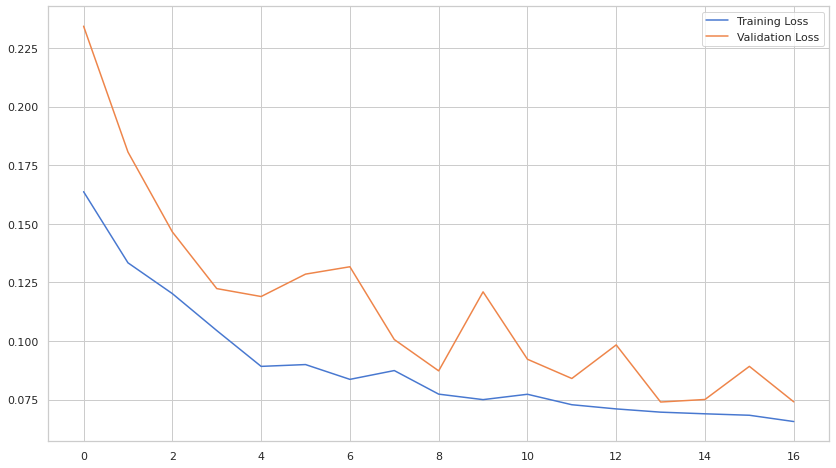

In [14]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

In [0]:
X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

In [16]:
model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 21ms/step - loss: 0.1093


0.1092987060546875

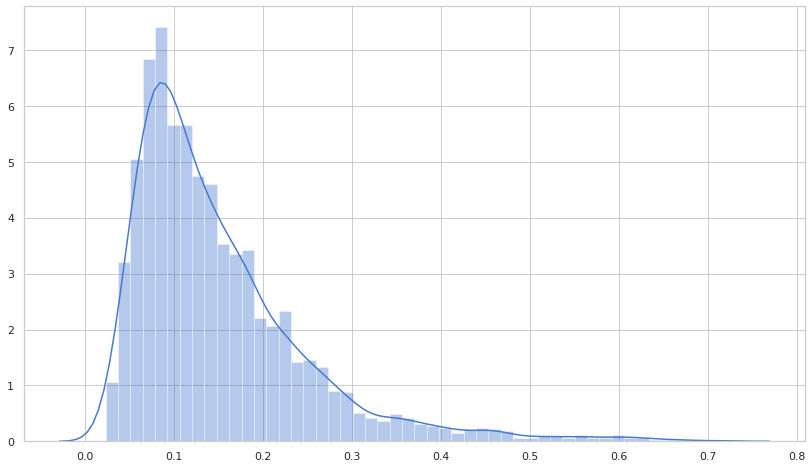

In [17]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [0]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

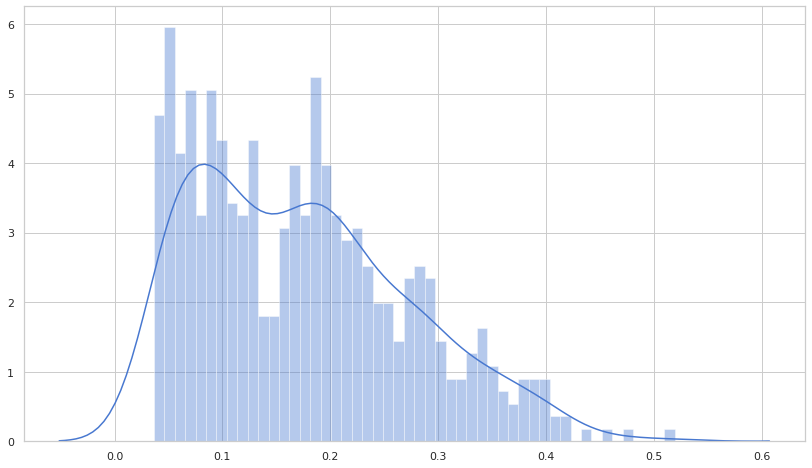

In [19]:
sns.distplot(test_mae_loss, bins=50, kde=True);

In [0]:
THRESHOLD = 0.4

test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['Close'] = test[time_steps:].Close

In [26]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].Date, y=test_score_df.loss,
                    mode='lines',
                    name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].Date, y=test_score_df.threshold,
                    mode='lines',
                    name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [27]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,Date,Open,High,Low,Close,Volume,Name,loss,threshold,anomaly
2560,2016-03-08,33.66,33.82,32.84,0.863524,21007332,AABA,0.403200,0.4,True
2930,2017-08-24,66.06,66.20,65.34,4.139647,4055765,AABA,0.419650,0.4,True
2931,2017-08-25,65.41,65.56,64.26,4.040066,5941278,AABA,0.402496,0.4,True
2975,2017-10-27,66.60,67.73,65.87,4.342833,7607822,AABA,0.411716,0.4,True
3001,2017-12-05,67.10,69.38,66.62,4.404191,11963099,AABA,0.474726,0.4,True


In [31]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].Date, y=scaler.inverse_transform(test[time_steps:].Close),
                    mode='lines',
                    name='Close Price'))
fig.add_trace(go.Scatter(x=anomalies.Date, y=scaler.inverse_transform(anomalies.Close),
                    mode='markers',
                    name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()